In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import xarray as xr
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/home/cucchi/phd/devel/phd/')
DATA_FORCING_PATH = '/home/cucchi/phd/data/sim/lorenz96/rk4/DF_8_0.5_0/'

Load data without and with forcing

In [7]:
data_noforcing = xr.open_dataarray('/home/cucchi/phd/data/sim/lorenz96/rk4/CF_8/sim_lorenz96_rk4_CF_8_one_00000.nc')
data_forcing = []
for i in range(0, 10):
    data_forcing.append(
        xr.open_dataarray(os.path.join(DATA_FORCING_PATH,'sim_lorenz96_rk4_DF_8_0.5_0_one_{:05}.nc'.format(i)))
    )

Compute observable (energy)

In [8]:
obs_noforcing = 0.5*(data_noforcing**2)
obs_forcing = []
for data in data_forcing:
    obs = 0.5*(data)**2
    obs.attrs = data.attrs
    obs_forcing.append(obs)

Compute average response

In [9]:
responses = []
for obs in obs_forcing:
    obs_noforcing_sel = obs_noforcing.sel(time_step = obs.time_step.values + obs.time_step_0_real)
    rescaled_time_steps = obs_noforcing_sel.time_step.values - obs_noforcing_sel.time_step.values[0]
    obs_noforcing_sel = obs_noforcing_sel.assign_coords(time_step=rescaled_time_steps)
    response = obs - obs_noforcing_sel
    responses.append(response)
responses = xr.concat(responses, dim='sim')
response_mean = responses.mean(dim='sim')

In [18]:
response_mean.rename('energy')

<xarray.DataArray 'energy' (time_step: 10000, node: 1)>
array([[0.      ],
       [0.003899],
       [0.003906],
       ...,
       [0.559904],
       [0.799083],
       [1.055738]], dtype=float32)
Coordinates:
  * node       (node) int32 0
  * time_step  (time_step) int32 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

Plot average response

In [20]:
response_mean.attrs['forcing'] = 'DF_8_0.5_0'

In [21]:
response_mean

<xarray.DataArray 'var' (time_step: 10000, node: 1)>
array([[0.      ],
       [0.003899],
       [0.003906],
       ...,
       [0.559904],
       [0.799083],
       [1.055738]], dtype=float32)
Coordinates:
  * node       (node) int32 0
  * time_step  (time_step) int32 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Attributes:
    forcing:  DF_8_0.5_0

Now, the average response to the delta force should be tge Green Function. Computing it's Fourier Transform, I should obtain the Susceptibility.

Padding and circular shift, for computational reasons

In [11]:
nt = response_mean.shape[0]
nfft = 2**(math.ceil(math.log2(abs(nt))))
response_mean_arr = response_mean.values[:,0]
response_mean_arr_extd = np.zeros(2*nfft)
response_mean_arr_extd[0:len(response_mean_arr)] = response_mean_arr
response_mean_arr_extd = np.roll(response_mean_arr_extd, nfft)

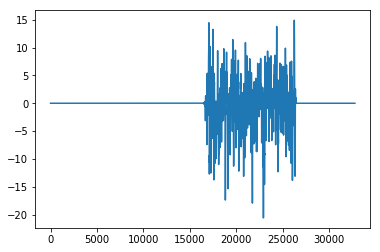

In [12]:
plt.plot(response_mean_arr_extd)

In [13]:
chi = np.fft.fft(response_mean_arr_extd)

In [14]:
chi_re = np.real(chi)
chi_im = np.imag(chi)

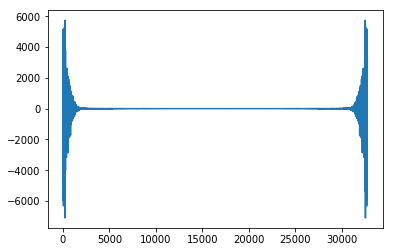

In [15]:
plt.plot(chi_re)

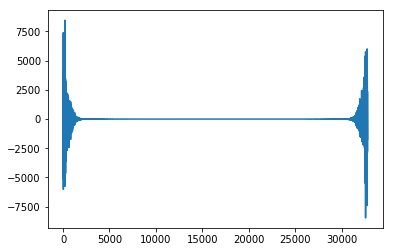

In [117]:
plt.plot(chi_im)

/home/cucchi/miniconda3/envs/l96/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


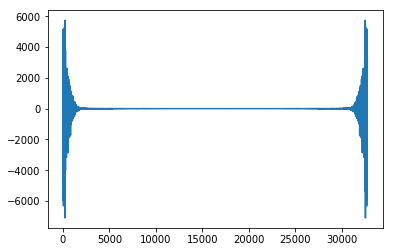

In [16]:
plt.plot(chi)